PREDICTING THE S&P500

In my exploratory data analysis I fit several models based on weekly S&P 500 Data, I found that all of my models struggled to achieve any actual predictive power. My theory is that weekly data is effective for the normal week to week movements of the index, but I believe it struggles to capture the whole picture of the big movements. In 1 week the market can drastically change and a model only containing weekly data would really struggle to understand these movements. This inspired me to compile a dataset of daily data from the S&P 500 over the last 10 years that will hopefully allow me to capture the full picture of the data. My goal is to build a series of models and find one with ACTUAL predictive power, that can aid small companies in making and maintaing conviction in their financial decisions.

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as tsaplots
import warnings
warnings.filterwarnings("ignore")

In [197]:
data = pd.read_csv('data/SP500dailydata.csv')

In [198]:
data.info()
data['Date'] = pd.to_datetime(data['Date'])
data= data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         2485 non-null   object 
 1   sp_500_prev_day_close        2485 non-null   float64
 2   sp_500_prev_day_open         2485 non-null   float64
 3   sp_500_prev_day_high         2485 non-null   float64
 4   sp_500_prev_day_low          2485 non-null   float64
 5   prev_day_rsi                 2485 non-null   float64
 6   rsi_overbought               2485 non-null   float64
 7   rsi_oversold                 2485 non-null   float64
 8   vix_prev_day                 2485 non-null   float64
 9   nasdaq_prev_day              2485 non-null   float64
 10  russell_2000_prev_day        2485 non-null   float64
 11  prev_volume                  2485 non-null   float64
 12  close_price                  2485 non-null   float64
 13  fed_ news_sentimen

Below I created a column for log returns, log returns are stationary- making then more easily digestible for time series models.

In [199]:
data['log_returns'] = np.log(data['close_price']).diff().dropna()
data['points_change'] = data['close_price'].diff().dropna()

I have also decided to include several different moving averages, as they can help identify trends and also reduce noise in the dataset.

In [200]:
data['5_day_moving_average'] = data['sp_500_prev_day_close'].rolling(window=5).mean()
data['10_day_moving_average'] = data['sp_500_prev_day_close'].rolling(window=10).mean()
data['20_day_moving_average'] = data['sp_500_prev_day_close'].rolling(window=20).mean()
data['50_day_moving_average'] = data['sp_500_prev_day_close'].rolling(window=50).mean()
data['200_day_moving_average'] = data['sp_500_prev_day_close'].rolling(window=200).mean()

In [201]:
data['prev_volume']=data['prev_volume'].astype(int)
data['positive_percent']=data['positive_percent'].astype(float)
data['negative_percent']=data['negative_percent'].astype(float)
data['neutral_percent']=data['neutral_percent'].astype(float)
data.to_csv('rsi.csv')


In [202]:
data = data.dropna()
data = pd.read_csv('data/rsi2.csv').dropna()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(data['Date'])
data= data.drop(['Date'],axis=1)
originaldata = data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2286 entries, 2016-07-08 to 2025-08-11
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sp_500_prev_day_close        2286 non-null   float64
 1   sp_500_prev_day_open         2286 non-null   float64
 2   sp_500_prev_day_high         2286 non-null   float64
 3   sp_500_prev_day_low          2286 non-null   float64
 4   prev_day_rsi                 2286 non-null   float64
 5   rsi_overbought               2286 non-null   int64  
 6   rsi_oversold                 2286 non-null   int64  
 7   vix_prev_day                 2286 non-null   float64
 8   nasdaq_prev_day              2286 non-null   float64
 9   russell_2000_prev_day        2286 non-null   float64
 10  prev_volume                  2286 non-null   int64  
 11  close_price                  2286 non-null   float64
 12  fed_ news_sentiment_index_   2286 non-null   float64
 13  

Below is a breakdown of all of the features in my dataset. It is essential to note that unless I specify otherwise, these datapoints are all taken from the previous day's data. So if the data is dated 1/2/25, the data in this row is actually from 1/1/25. This is because I am trying to use the previous data to predict the current day, we won't have the current day's data until the close of that day, so to build a properly working model its important to build it off only information we would have when we are making the predictions. 
 
     0   sp_500_prev_day_close: S&P 500 closing price from the previous day
     1   sp_500_prev_day_open: S&P 500 opening price from the previous day
     2   sp_500_prev_day_high: The highest point of the S&P 500 from the previous day
     3   sp_500_prev_day_low: The lowest point of the S&P 500 from the previous day
     4   prev_day_rsi: The Relative Strength Index reading from the previous day, this measures the speed and change of price movements to capture the underlying momentum of the S&P 500
     5   rsi_overbought: Registers a "1" if the RSI reading becomes greater than 70 - indicating the S&P 500 may be overbought - if not, it reads "0"
     6   rsi_oversold: Registers a "1" if the RSI reading drops below 30 - indicating the S&P 500 may be oversold - if not, it reads "0" 
     7   vix_prev_day: CBOE volatility index last price from the previous day. This is a good indicator of fear and volatility in the market.
     8   nasdaq_prev_daq: previous day's NASDAQ close price
     9  russell_2000_prev_day: previous day's Russell 2000 close price
     10  prev_volume: the amount of shares exchanged from the previous day 
     11  close_price: the close price from the current day (this will not be seen by the model)
     12  fed_ news_sentiment_index_: the previous day's sentiment index reading from FRED used to track market sentiment on a day to day basis
     13  positive_sentiment_prev_day: the number of articles my NLP model for sentiment analysis identified as "positive" from the previous day
     14  negative_sentiment_prev_day: the number of articles my NLP model for sentiment analysis identified as "negative" from the previous day
     15  neutral_sentiment_prev_day:  the number of articles my NLP model for sentiment analysis identified as "neutral" from the previous day
     16  sentiment_score_prev_day: the difference between the amount of "positive" and "negative" articles, to give it a singular sentiment score for the day.
     17  positive_percent: the percentage of articles my NLP model for sentiment analysis identified as "positive" from the previous day
     18  negative_percent: the percentage of articles my NLP model for sentiment analysis identified as "negative" from the previous day
     19  neutral_percent: the percentage of articles my NLP model for sentiment analysis identified as "neutral" from the previous day
     20  30_year_treasury: macroeconomic data- the most recent 30-year treasury yield reading from the previous day
     21  7_year__ treasury: macroeconomic data- the most recent 7-year treasury yield reading from the previous day
     22  2_year__ treasury: macroeconomic data- the most recent 2-year treasury yield reading from the previous day
     23  non_farm_payroll: macroeconomic data- the most recent non-farm payroll report number
     24  gdp: macroeconomic data- the most recent gdp numbers
     25  cpi: macroeconomic data- the most recent cpi report number
     26  log_returns: log returns for the CURRENT day - this will be my "Y" variable 
     27  points_change: the change in points from one day to the next
     28  5_day_moving_average: 5 day moving average from the previous day
     29  10_day_moving_average: 10 day moving average from the previous day
     30  20_day_moving_average: 20 day moving average from the previous day
     31 50_day_moving_average: 50 day moving average from the previous day
     32  200_day_moving_average: 200 day moving average from the previous day
     33  golden_cross_rating: indicates from the previous day if the short term moving average (50 days) is above the long term moving average(200 days), if so it registers a 1, if not it registers a 0.
     34  golden_cross: indicates if a golden cross started or ended on the previous day: it registers a 1 if a golden cross happened and a -1 if the short term moving average moved below the long term Moving average, most rows have 0's for this

In [203]:
data.sample(10)

,sp_500_prev_day_close,sp_500_prev_day_open,sp_500_prev_day_high,sp_500_prev_day_low,prev_day_rsi,rsi_overbought,rsi_oversold,vix_prev_day,nasdaq_prev_day,russell_2000_prev_day,...,cpi,log_returns,points_change,5_day_moving_average,10_day_moving_average,20_day_moving_average,50_day_moving_average,200_day_moving_average,golden_cross _rating,golden_cross
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-15,4489.72,4458.13,4490.33,4453.44,50.339736,0,0,14.82,13788.33,19.73,...,306.138,-0.011618,-51.86,4477.938,4497.817,4528.3765,4444.0228,4119.52915,1,0
2022-09-21,3855.93,3875.23,3876.01,3827.54,37.167001,0,0,27.16,11425.05,32.23,...,296.421,-0.017265,-66.00,3895.302,3957.302,3994.3220,4042.2340,4251.65310,0,0
2023-12-04,4594.63,4559.43,4599.39,4554.71,73.756478,1,0,12.63,14305.03,20.60,...,308.735,-0.005423,-24.85,4563.666,4553.116,4484.8800,4359.4670,4286.57460,1,0
2024-10-21,5864.67,5859.43,5872.17,5846.11,65.578874,0,0,18.03,18489.55,26.09,...,315.564,-0.001824,-10.69,5844.744,5805.791,5767.3495,5645.0840,5307.52200,1,0
2021-06-02,4204.11,4200.88,4218.36,4200.88,57.615516,0,0,17.90,13736.48,23.98,...,270.710,0.001446,6.08,4198.644,4174.876,4168.4220,4119.8920,3748.34725,1,0
2022-01-11,4670.29,4655.34,4673.02,4582.37,46.756596,0,0,19.40,14942.83,27.56,...,282.542,0.009118,42.78,4707.498,4745.837,4706.2990,4676.8198,4406.68300,1,0
2021-06-25,4266.49,4256.97,4271.28,4256.97,60.398246,0,0,15.97,14369.71,21.70,...,270.710,0.003325,14.21,4229.202,4234.075,4224.6610,4190.7608,3814.94230,1,0
2017-07-19,2460.61,2455.88,2460.92,2450.34,63.406252,0,0,9.89,6344.31,13.90,...,244.243,0.005358,13.22,2454.020,2438.700,2435.1850,2422.1554,2309.26995,1,0
2018-03-21,2716.94,2715.05,2724.22,2710.05,46.579496,0,0,18.20,7364.30,18.76,...,249.577,-0.001846,-5.01,2735.736,2747.935,2734.3815,2748.6186,2582.07215,1,0


Text(0, 0.5, 'Weekly Closing Price ($)')

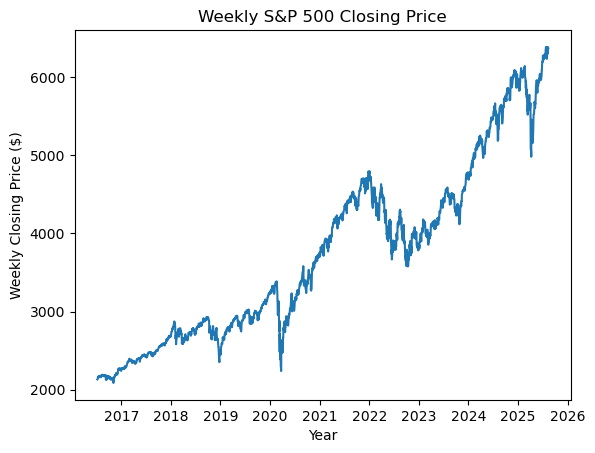

In [204]:
#This plot shows the weekly closing price of the S&P500 since 1982
plt.plot(data['close_price'])
plt.title('Weekly S&P 500 Closing Price')
plt.xlabel('Year')
plt.ylabel('Weekly Closing Price ($)')

Text(0, 0.5, 'Change in Price')

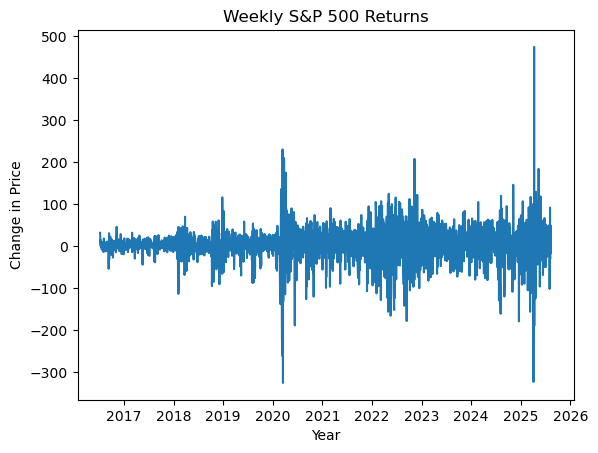

In [205]:
#This plot shows the weekly returns of the S&P500 in %
plt.plot(data['points_change'])
plt.title('Weekly S&P 500 Returns')
plt.xlabel('Year')
plt.ylabel('Change in Price')

Below is a graph of the Sentiment index from the FRED in San Francisco on daily sentiment

Text(0, 0.5, 'Sentiment Index')

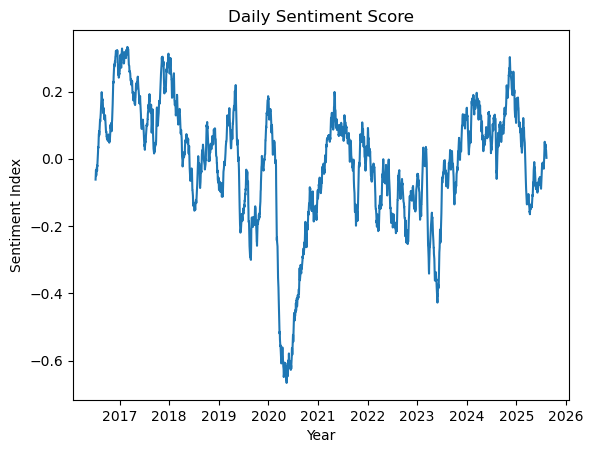

In [206]:
#This plot shows the weekly returns of the S&P500 in %
plt.plot(data['fed_ news_sentiment_index_'])
plt.title('Daily Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Sentiment Index')

Now i'll start preparing the data for modeling: Rather than predicting the actual price of the S&P500, or its simple returns, i have opted to predict log returns. Log returns I believe will be easier for both the model and myself to interpret. Log Returns should be closer to a normal distrubution, which should make it easier to interpret for the models. Also they are easy to transform, after the fact, to dollar amounts.

In [207]:
X= data.drop(['log_returns','close_price','points_change'],axis=1).dropna()
y=data['log_returns'].dropna()

Now I will make an initial Linear Regression. Linear Regressions aren't typically used to model time series data, so I am using this as somewhat of a baseline to see how it will perform. I don't expect this model to be accurate at all, but it will give us an idea of how nuanced financial data is and how crucial the sequential aspect is of it.

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [273]:
y_test

Date
2023-05-01   -0.000386
2023-05-02   -0.011654
2023-05-03   -0.007023
2023-05-04   -0.007245
2023-05-05    0.018306
                ...   
2025-08-05   -0.004870
2025-08-06    0.007256
2025-08-07   -0.000798
2025-08-08    0.007769
2025-08-11   -0.002507
Name: log_returns, Length: 572, dtype: float64

Below I have transformed the data to make it stationary. This data will be more suitable to the time series models which perform best with stationary data.

In [285]:
X1_train = X_train.diff().dropna()
X1_test = X_test.diff().dropna()
y1_train = y_train.loc['2016-07-11':'2023-04-28']
y1_test = y_test.loc['2023-05-02':'2025-08-11']

In [286]:
X1_train



,sp_500_prev_day_close,sp_500_prev_day_open,sp_500_prev_day_high,sp_500_prev_day_low,prev_day_rsi,rsi_overbought,rsi_oversold,vix_prev_day,nasdaq_prev_day,russell_2000_prev_day,...,non_farm_payroll,gdp,cpi,5_day_moving_average,10_day_moving_average,20_day_moving_average,50_day_moving_average,200_day_moving_average,golden_cross _rating,golden_cross
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-11,32.00,6.54,22.63,17.57,6.499815,0.0,0.0,-1.56,79.95,-1.82,...,0.0,0.0,0.0,6.208,1.658,0.7210,0.6950,0.93580,0.0,0.0
2016-07-12,7.26,24.75,11.45,24.75,1.316883,0.0,0.0,0.34,31.88,-1.07,...,0.0,0.0,0.0,6.844,9.975,2.0545,1.2270,0.99200,0.0,0.0
2016-07-13,14.98,7.79,12.24,7.79,2.631994,0.0,0.0,0.01,34.18,-0.29,...,0.0,0.0,0.0,9.840,15.160,3.6540,1.7368,1.09950,0.0,0.0
2016-07-14,0.28,14.31,1.04,6.71,0.049238,0.0,0.0,-0.51,-17.09,-0.04,...,0.0,0.0,0.0,10.538,11.633,3.8550,1.4200,1.10540,0.0,0.0
2016-07-15,11.33,4.07,12.54,11.67,2.019954,0.0,0.0,-0.22,28.33,0.35,...,0.0,0.0,0.0,13.170,9.298,4.6125,2.0076,1.40990,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,3.73,1.66,-10.55,-0.71,0.511476,0.0,0.0,-0.40,12.90,-0.33,...,0.0,0.0,0.0,-0.824,2.850,9.2400,0.3132,1.44220,0.0,0.0
2023-04-25,3.52,-0.07,4.39,3.91,0.506819,0.0,0.0,0.12,-35.26,0.08,...,0.0,0.0,0.0,-2.856,3.202,8.3025,1.1108,1.17210,0.0,0.0
2023-04-26,-65.41,-5.64,-15.98,-46.14,-12.133311,0.0,0.0,1.87,-238.04,2.82,...,0.0,0.0,0.0,-16.648,-3.731,4.7050,-0.3766,0.86125,0.0,0.0


In [287]:
numerical=['sp_500_prev_day_close','vix_prev_day','nasdaq_prev_day','russell_2000_prev_day','prev_volume','fed_ news_sentiment_index_','5_day_moving_average','10_day_moving_average','20_day_moving_average','50_day_moving_average','200_day_moving_average','2_year__ treasury','7_year__ treasury','30_year_treasury','prev_day_rsi','sp_500_prev_day_open','sp_500_prev_day_high','sp_500_prev_day_low','cpi','non_farm_payroll','gdp']

In [288]:
# This is the transformer for my regression model, it will transform and scale the data to hopefully fit the data better.
polytransformer = Pipeline([        
                                    ('poly',PolynomialFeatures(degree = 3,include_bias=False)),
                                    ('scale',StandardScaler())
                                ])
transformer = [('polynomialtransformations',polytransformer,numerical)]
transform = ColumnTransformer(transformers = transformer,remainder='passthrough')

I have decided to forgo removing/filling any outliers, my thought is that because of the nature of financial data, outliers are important datapoints for the model to understand in this circumstance. For example, although the rapid changes during COVID are definitely outliers, rapid changes like this do happen in financial markets, so I believe the models should be aware of what they look like.

In [289]:
linregpipeline = Pipeline([
    ('transform',transform),
    ('reg',Ridge(alpha = 10000))
]).fit(X1_train,y1_train)

In [290]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
linregpipeline.fit(X1_train,y1_train)

,steps,"[('transform', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('polynomialtransformations', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [294]:
linreg_train_preds = linregpipeline.predict(X1_train)
linreg_test_preds = linregpipeline.predict(X1_test)
linregtrainerror = mean_squared_error(linreg_train_preds,y1_train)
linregerror = mean_squared_error(linreg_test_preds,y1_test)

Now that our model is trained, I have decided to use Root Mean Squared Error (RMSE) as the test metric for all of my models. I decided to use RMSE for two main reasons:

    1) Penalizing Errors:  In financial modeling there is not much room for large errors as a predicition with a large             error could lead to a catastrophic financial decisions. RMSE penalizes large errors naturally, making it ideal for          financial modeling. 
    
    2) Interpretability: It operates on the same units as my original target variable. This makes it easy to understand how        the model is performing. Although it is using log odds, it is easily convertible afterwards.

Using Root Mean Squared Error will allow us to compare our predicted log returns with actual log returns. While there is some margin for error, generally log returns can be read like simple returns. For example, a 5% increase in simple returns would equal a .05 log return. While this is inexact, it generally is a very good approximation, so going forward this is how I will prepare the units.

In [295]:
# BELOW IS THE RMSE OF OUR INITIAL FUNCTION 
print(f"The training RMSE is: {np.sqrt(linregtrainerror)}")
print(f"The test RMSE is: {np.sqrt(linregerror)}")

The training RMSE is: 0.010374916303423616
The test RMSE is: 0.012669210031831678


This standard linear regression gave us an RMSE of .0127, which is much better than how it performed on the weekly data. This shows that our linear regression model on average can predict the following day's change within about 1.27%. For actual financial use this would be quite an ineffective model. This is happening because the linear regression is not meant to handle sequential data like this. When you think about how quickly financial changes can happen like during COVID and in 2008, it makes sense that the model can't predict forward multiple years of how the S&P 500 is going to move.

Now that we have seen how poorly a standard linear regression performs, I will build a true baseline model, called a Random Walk, that will actually give us some information to base our proceeding models off of. In an earlier line, I created a transformed version of the original data that took the difference of each line. 

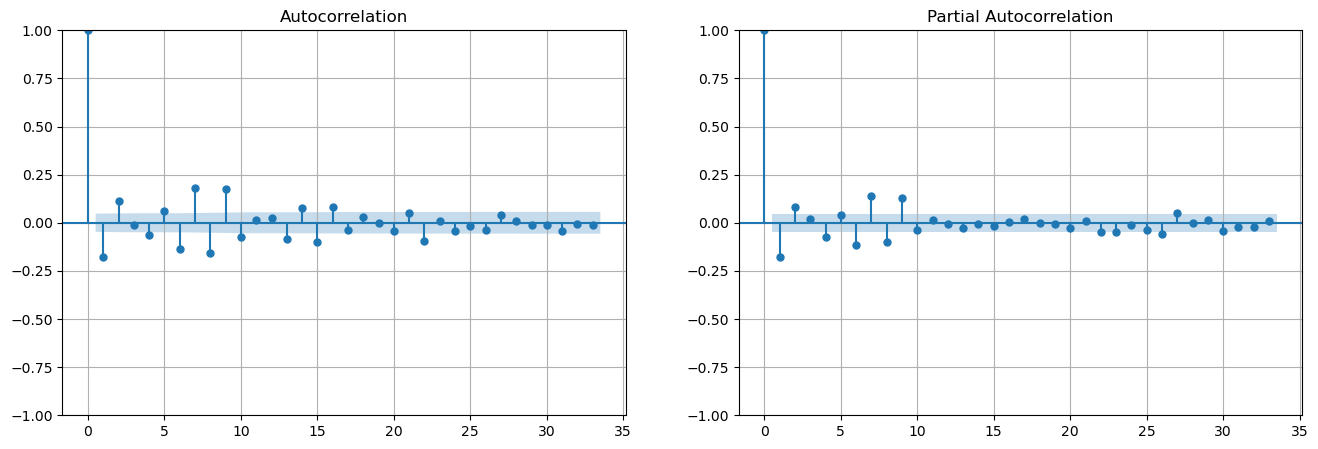

In [296]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y1_train, ax = ax[0]);
ax[0].grid()
plot_pacf(y1_train, ax = ax[1], method = 'ywm');
ax[1].grid()

In [297]:
randomwalk = SARIMAX(y1_train, order=(0, 1, 0), trend='c').fit()

In [298]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
randomwalk_preds = randomwalk.predict(start=start_index, end=end_index)
random_mse_test = mean_squared_error(randomwalk_preds, y1_test)
### ANSWER CHECK
print(randomwalk_preds)
print(random_mse_test)
print(f" RMSE: {np.sqrt(random_mse_test)}")

1713    0.008222
1714    0.008225
1715    0.008228
1716    0.008230
1717    0.008233
          ...   
2279    0.009765
2280    0.009767
2281    0.009770
2282    0.009773
2283    0.009775
Name: predicted_mean, Length: 571, dtype: float64
0.00016379902432210413
 RMSE: 0.01279839928749311


The Random Walk gave us a baseline RMSE of .138, this gives us a baseline to gauge the other models off. If the model can do better than this "naive" approach, then we are off to a good start and shows that the model has actual predcitive power. This shows 

Below I am building a standard ARMA model, this model will use regression and moving averages of previous log returns to predict the next weeks log returns

In [300]:
arima = ARIMA(y1_train, order = (1, 0, 1)).fit()

In [301]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
arima_preds_array = arima.predict(
    start=start_index,
    end=end_index,
)
arima_predicted_test = arima.predict(start=start_index, end=end_index)
arima_mse_test = mean_squared_error(arima_predicted_test, y1_test)
arima_preds = pd.Series(arima_preds_array.values, index=y1_test.index)
arima_mse_test = mean_squared_error(arima_preds, y1_test)
### ANSWER CHECK
print(f" RMSE: {np.sqrt(arima_mse_test)}")
print(f" RMSE: {np.sqrt(arima_mse_test)}")
print(f" RMSE: {np.sqrt(arima_mse_test)}")

 RMSE: 0.009772897804422379
 RMSE: 0.009772897804422379
 RMSE: 0.009772897804422379


Below I am building a SARIMAX model, it is a similar concept to the ARIMA I built previously, but allows me to pass through exogenous data like data from other indicies and economic factors. My hope is that this model will be able to combine the sequential nature of the data and the economic data and be able to effectively predict using both. 

In [307]:
sarimax = SARIMAX(y1_train,exog=X1_train,  order=(3, 0, 1), seasonal_order=(0, 0, 0, 0)).fit()

In [308]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 1713
Model:               SARIMAX(3, 0, 1)   Log Likelihood                5203.170
Date:                Wed, 20 Aug 2025   AIC                         -10332.340
Time:                        02:48:17   BIC                         -10130.838
Sample:                             0   HQIC                        -10257.772
                               - 1713                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sp_500_prev_day_close       -8.013e-05   1.74e-05     -4.598      0.000      -0.000    -4.6e-05
sp_500_prev_day_open        -9.202e-06   1.42e-05     -0.649      0.516    -3.7e-05    1.86e-05
sp_500_prev_day_high        -2.649e-05   1.62e-05     -1.631      0.103   -5.83e-05    5.34e-06
sp_500_prev_day_low          3.569e-05   1.58e-05      2.264      0.024    4.79e-06    6.66e-05
prev_day_rsi                    0.0006   9.41e-05      6.325      0.000       0.000       0.001
rsi_overbought                 -0.0015   7.92e-07  -1872.153      0.000      -0.001      -0.001
rsi_oversold                    0.0089   2.01e-06   4427.247      0.000       0.009       0.009
vix_prev_day                   -0.0002   7.45e-05     -3.284      0.001      -0.000   -9.86e-05
nasdaq_prev_day              7.106e-06   3.95e-06      1.798      0.072   -6.39e-07    1.49e-05
russell_2000_prev_day           0.0016   6.77e-05     23.497      0.000       0.001       0.002
prev_volume                  1.651e-11    9.9e-12      1.667      0.095    -2.9e-12    3.59e-11
fed_ news_sentiment_index_      0.0444   1.62e-07   2.73e+05      0.000       0.044       0.044
positive_sentiment_prev_day    -0.0001   7.96e-05     -1.626      0.104      -0.000    2.66e-05
negative_sentiment_prev_day    -0.0006   5.43e-05    -11.441      0.000      -0.001      -0.001
neutral_sentiment_prev_day      0.0003      0.000      2.546      0.011    6.73e-05       0.001
sentiment_score_prev_day        0.0005   5.05e-05      9.731      0.000       0.000       0.001
positive_percent               -0.0012   4.56e-06   -257.248      0.000      -0.001      -0.001
negative_percent                0.0059   3.18e-06   1864.402      0.000       0.006       0.006
neutral_percent                -0.0047   5.48e-06   -865.677      0.000      -0.005      -0.005
30_year_treasury                1.2833   1.18e-08   1.09e+08      0.000       1.283       1.283
7_year__ treasury              -1.9297   8.78e-09   -2.2e+08      0.000      -1.930      -1.930
2_year__ treasury              -0.8666   7.73e-09  -1.12e+08      0.000      -0.867      -0.867
non_farm_payroll            -1.788e-09   3.43e-09     -0.521      0.602   -8.51e-09    4.93e-09
gdp                         -7.807e-07   4.74e-06     -0.165      0.869   -1.01e-05     8.5e-06
cpi                             0.0016   1.49e-06   1094.317      0.000       0.002       0.002
5_day_moving_average          2.06e-05   1.65e-05      1.250      0.211   -1.17e-05    5.29e-05
10_day_moving_average        2.773e-05   3.08e-05      0.900      0.368   -3.27e-05    8.81e-05
20_day_moving_average        3.416e-05   3.85e-05      0.888      0.375   -4.13e-05       0.000
50_day_moving_average          -0.0002   6.49e-05     -2.730      0.006      -0.000      -5e-05
200_day_moving_average          0.0001      0.000      0.896      0.370      -0.000       0.000
golden_cross _rating            0.0022    2.7e-07   8165.647      0.000  

In [309]:

sarimax = SARIMAX(y1_train, exog=X1_train, order=(3, 0, 1), seasonal_order=(0, 0, 0, 0)).fit()
sarimax_start_index = len(y1_train)
sarimax_end_index = len(y1_train) + len(y1_test) - 1
sarimax_preds_array = sarimax.predict(
    start=sarimax_start_index,
    end=sarimax_end_index,
    exog=X1_test,
    dynamic=False
)
sarimax_preds = pd.Series(sarimax_preds_array.values, index=y1_test.index)
sarimax_mse_test = mean_squared_error(sarimax_preds, y1_test)

print("SARIMAX Predictions:")
print(sarimax_preds)
print(f"\nSARIMAX MSE (Test Set): {sarimax_mse_test}")
print(f"\nSARIMAX RMSE (Test Set): {np.sqrt(sarimax_mse_test)}")

SARIMAX Predictions:
Date
2023-05-02    0.000539
2023-05-03    0.005337
2023-05-04    0.002178
2023-05-05    0.004437
2023-05-08   -0.006479
                ...   
2025-08-05   -0.002781
2025-08-06   -0.000586
2025-08-07   -0.000138
2025-08-08   -0.006484
2025-08-11    0.002458
Length: 571, dtype: float64

SARIMAX MSE (Test Set): 0.00011516632250995954

SARIMAX RMSE (Test Set): 0.01073155731988417


In [310]:
print(f" RMSE: {np.sqrt(sarimax_mse_test)}")

 RMSE: 0.01073155731988417


In [311]:
price = originaldata['close_price'].loc['2022-11-11':'2025-8-20']
logreturns = originaldata['log_returns'].loc['2022-11-11':'2025-8-20']
price

Date
2022-11-11    3992.93
2022-11-14    3957.25
2022-11-15    3991.73
2022-11-16    3958.79
2022-11-17    3946.56
               ...   
2025-08-05    6299.19
2025-08-06    6345.06
2025-08-07    6340.00
2025-08-08    6389.45
2025-08-11    6373.45
Name: close_price, Length: 687, dtype: float64

In [312]:
last_actual_price = 3992.93

In [314]:
predicted_results = pd.DataFrame(originaldata['sp_500_prev_day_open'].loc['2023-05-02':'2025-08-11'])
predicted_results['close_price'] = originaldata['close_price'].loc['2023-05-02':'2025-08-11']
predicted_results['difference'] = originaldata['points_change'].loc['2023-05-02':'2025-08-11']
predicted_results['log_returns']= y1_test
predicted_results['sarimax_predicted_logreturns'] = sarimax_preds
predicted_results['sarimax_return_difference'] = predicted_results['sarimax_predicted_logreturns']-predicted_results['log_returns']
predicted_results['arima_predicted_logreturns']= arima_preds
predicted_results['arima_return_difference']=predicted_results['arima_predicted_logreturns']-predicted_results['log_returns']
predicted_results['lin_reg_predicted_logreturns'] = linreg_test_preds
predicted_results['lin_reg_return_difference'] = predicted_results['lin_reg_predicted_logreturns']-predicted_results['log_returns']
predicted_results

,sp_500_prev_day_open,close_price,difference,log_returns,sarimax_predicted_logreturns,sarimax_return_difference,arima_predicted_logreturns,arima_return_difference,lin_reg_predicted_logreturns,lin_reg_return_difference
Date,,,,,,,,,,
2023-05-02,4166.79,4119.58,-48.29,-0.011654,0.000539,0.012193,0.000139,0.011793,-0.000391,0.011263
2023-05-03,4164.10,4090.75,-28.83,-0.007023,0.005337,0.012360,0.000515,0.007537,0.000673,0.007696
2023-05-04,4122.25,4061.22,-29.53,-0.007245,0.002178,0.009423,0.000326,0.007571,0.000156,0.007401
2023-05-05,4082.55,4136.25,75.03,0.018306,0.004437,-0.013869,0.000421,-0.017885,0.000722,-0.017584
2023-05-08,4084.73,4138.12,1.87,0.000452,-0.006479,-0.006931,0.000373,-0.000079,-0.001915,-0.002367
...,...,...,...,...,...,...,...,...,...,...
2025-08-05,6271.71,6299.19,-30.75,-0.004870,-0.002781,0.002089,0.000389,0.005259,-0.002511,0.002359
2025-08-06,6336.63,6345.06,45.87,0.007256,-0.000586,-0.007842,0.000389,-0.006866,0.000314,-0.006942
2025-08-07,6309.30,6340.00,-5.06,-0.000798,-0.000138,0.000660,0.000389,0.001187,0.000694,0.001492


Out of the 3 models, the ARIMA was the most succesful, but the SARIMAX I found to be the most practical for day to day use. While the ARIMA produced the best RMSE on the test set, the further out the predictions got, the less variance there was between guesses and eventually it was predicting the same thing over and over again. This shows me that at a certain point it just made the most sense to use a value of about 0.000389 everyday to be the most accurate. But when it comes to actually predicting for a day to day use this is not effective. I think this could be an effective tool to use though over a longer period of time to estimate where we will be a few weeks/months from now. Log returns are additive, so I think this could be a decent tool to predict perhaps a month ahead. 

The SARIMAX, produced a higher RMSE of about .0107, this means that on average it's prediction would be about 1% off. 1% is huge when it comes to financial markets, so this is not a great way to predict the following days price, but it does beat the "naive" approaches I mentioned off.
    Example: So essentially this means if you were wanting to predict the following day's S&P 500 return, it would be superior to using the 'naive', random walk. So if you are planning on using a naive approach to deciding how an investment will move the following day, trust the model instead, it will give you a better chance at correctly predicting movements. But this would not be a great tool to use for serious financial use.

Below I am building an LSTM, first I will take the difference of the data and scale it to ensure that the data is Stationary and ready to be modeled.

In [353]:
lstmdata = data.drop(['close_price','points_change'],axis=1)
result = adfuller(lstmdata['log_returns'])

# The result is a tuple, so we can unpack it
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -15.062877
p-value: 0.000000
Critical Values:
	1%: -3.433225137154697
	5%: -2.862810165650807
	10%: -2.5674461676068314


In [354]:
features = lstmdata.columns.tolist()

In [355]:
train = lstmdata['2015-9-1':'2023-05-01'].diff().dropna()
test = lstmdata['2023-05-02':].diff().dropna()

In [356]:
#SCALED DATA:
train_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(train)
test_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(test)

In [357]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [358]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 5])
    return np.array(X), np.array(y)



In [359]:

seq_length = 30  
X3_train, y3_train = create_sequences(train_scaled, seq_length)
X3_test, y3_test = create_sequences(test_scaled, seq_length)


In [360]:
print("X_train shape:", X3_train.shape)
print("y_train shape:", y3_train.shape)
print("X_test shape:", X3_test.shape)
print("y_test shape:", y3_test.shape)
n_timesteps = X3_train.shape[1]
n_features = X3_train.shape[2]

X_train shape: (1684, 30, 33)
y_train shape: (1684,)
X_test shape: (540, 30, 33)
y_test shape: (540,)


In [361]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X3_train.shape[1], X3_train.shape[2])))
lstm.add(LSTM(units=50, return_sequences=False))
lstm.add(Dense(units=25))
lstm.add(Dense(units=1))

In [362]:
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
print("Training the LSTM model...")
history = lstm.fit(
    X3_train,
    y3_train,
    epochs=100,
    batch_size=32,
    validation_data=(X3_test, y3_test),
    callbacks=[callback],
    verbose=1
)
print("Training complete.")



Training the LSTM model...
Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0373 - val_loss: 0.0290
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0124 - val_loss: 0.0222
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0123 - val_loss: 0.0229
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0125 - val_loss: 0.0201
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0122 - val_loss: 0.0219
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0122 - val_loss: 0.0255
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0120 - val_loss: 0.0195
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0129 - val_loss: 0.0204
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0121 - val_loss: 0.0210
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0121 - val_loss: 0.0231
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0121 - val_loss: 0.0242
Epoch 12/100
53/53 ━━━━━━

In [363]:

print("Evaluating model performance on the test set...")
# Make predictions on the test set
y_pred_scaled = lstm.predict(X3_test)

# Inverse transform predictions and actual values to their original scale
# This is a critical step for meaningful evaluation
y_test_unscaled = np.zeros(shape=(len(y3_test), len(features)))
y_pred_unscaled = np.zeros(shape=(len(y_pred_scaled), len(features)))

y_test_unscaled[:, 0] = y3_test
# Select the last timestep prediction from the sequence output and flatten
y_pred_unscaled[:, 0] = y_pred_scaled[:, -1, 0] if y_pred_scaled.ndim == 3 else y_pred_scaled.flatten()

y_test_unscaled = scaler.inverse_transform(y_test_unscaled)[:, 0]
y_pred_unscaled = scaler.inverse_transform(y_pred_unscaled)[:, 0]


Evaluating model performance on the test set...
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [364]:
lstmmse = mean_squared_error(predictions, actual_prices)
lstmrmse = np.sqrt(lstmmse)
print(f"Mean Squared Error: {lstmmse:.4f}")
print(f"Root Mean Squared Error: {lstmrmse:.4f}")

Mean Squared Error: 5328.1233
Root Mean Squared Error: 72.9940


The above model is not practical at all, I don't believe the data is robust enough to work with an LSTM